In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from functools import partial
from tensorflow.keras.applications.vgg16 import VGG16
import glob
import pandas as pd

2023-04-11 18:22:10.253254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Pandas Below:

In [46]:
# dataset_path = '/Users/George_1/PycharmProjects/MLFINAL2/funny.csv'
# data = pd.read_csv(dataset_path)
#
# def download_image(url):
#     try:
#         response = requests.get(url, timeout=5)
#         img = Image.open(io.BytesIO(response.content))
#         return img
#     except:
#         return None
#
# # Download the images
# images = []
# scores = []
#
# for index, row in data.iterrows():
#     url = row['url']
#     score = row['score']
#     img = download_image(url)
#
#     if img is not None:
#         images.append(img)
#         scores.append(score)
#
#
# input_size = (128, 128)
# threshold = 100
# X = np.array([np.array(img.convert('RGB').resize(input_size[:2])) for img in images])
# y = np.array(['1' if score > threshold else '0' for score in scores])
#
#
# encoder = LabelEncoder()
# y = encoder.fit_transform(y)
# shuffled_indices = np.random.permutation(len(X))
# X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)
#
# X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import requests
import io
from PIL import Image


dataset_path = '/Users/George_1/PycharmProjects/MLFINAL2/funny.csv'
data = pd.read_csv(dataset_path)

def download_image(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(io.BytesIO(response.content))
        return img
    except:
        return None

# Download the images
images = []
scores = []

for index, row in data.iterrows():
    url = row['url']
    score = row['score']
    img = download_image(url)

    if img is not None:
        images.append(img)
        scores.append(score)


input_size = (128, 128)
X = np.array([np.array(img.convert('RGB').resize(input_size[:2])) for img in images])

# Define the range of threshold values to search
param_grid = {'logisticregression__C': [0.1, 1, 10, 100]}

# Split the data into training and validation sets
y = np.array(['1' if score > 0 else '0' for score in scores])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline for training the logistic regression classifier
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define the scoring function for the grid search
scorer = make_scorer(accuracy_score)

# Perform the grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Print the best C value and corresponding validation score
print('Best C:', grid_search.best_params_['logisticregression__C'])
print('Validation score:', grid_search.best_score_)

# Define the labels based on the optimal threshold
model = grid_search.best_estimator_.named_steps['logisticregression']
threshold = 0.5  # Change this to the desired threshold
y_pred = (model.predict_proba(X_val.reshape(X_val.shape[0], -1))[:, 1] > threshold).astype(int)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_pred = encoder.transform(y_pred)

# Train the final model on the entire training set
model.fit(X.reshape(X.shape[0], -1), y)

# Split the remaining data into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Define the labels for the test set using a threshold of 0.5
y_test = (model.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1] > 0.5).astype(int)

# Evaluate the final model on the test set
accuracy = accuracy_score(y_test, encoder.transform(y_test))
print('Test accuracy:', accuracy)


In [45]:
from sklearn.metrics import accuracy_score

def get_accuracy(threshold):
    y_pred = (y_val > threshold).astype(int)
    return accuracy_score(y_val, y_pred)

# Define the range of threshold values to search
threshold_range = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Use grid search to find the threshold with the highest accuracy
best_threshold = None
best_accuracy = 0
for threshold in threshold_range:
    accuracy = get_accuracy(threshold)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print('Best threshold:', best_threshold)
print('Best accuracy:', best_accuracy)


Best threshold: 100
Best accuracy: 0.7796610169491526


In [ ]:
import matplotlib.pyplot as plt

# Select some random indices to plot
indices = np.random.choice(len(X_train), size=10, replace=False)

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5)
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[indices[i]])
    ax.set_title('Score: {}'.format(y_train[indices[i]]))
    ax.axis('off')

plt.show()


#Tensor Flow Below:

In [5]:
# def download_and_process_image(url, input_size):
#     try:
#         response = requests.get(url, timeout=5)
#         img = Image.open(io.BytesIO(response.content))
#         img = img.convert('RGB').resize(input_size, Image.LANCZOS)
#         img = tf.image.resize(img, [224, 224], method=tf.image.ResizeMethod.BILINEAR)
#         img.set_shape((224, 224, 3))
#         return np.array(img)
#     except:
#         return np.zeros(input_size + (3,), dtype=np.uint8)
#
# def parse_csv(*cols):
#     url = cols[0]  # Assuming the 'url' column is the first column in the CSV file
#     score = cols[1]  # Assuming the 'score' column is the second column in the CSV file
#     return url, score
#
# def process_data(url, score, input_size):
#     img = tf.py_function(partial(download_and_process_image, url.numpy()), [input_size], tf.uint8)
#     label = tf.cast(score > threshold, tf.int32)
#     return img, label
#
#
#
# def count_elements_in_dataset(dataset):
#     count = 0
#     for _ in dataset:
#         count += 1
#     return count
#
# dataset_path = '/Users/George_1/PycharmProjects/MLFINAL2/funny.csv'
# input_size = (224, 224)
# threshold = 1000
# record_defaults = [tf.constant("", dtype=tf.string), tf.constant(0, dtype=tf.int32)]
#
# # Load the CSV file
# dataset = tf.data.experimental.CsvDataset(dataset_path, record_defaults, header=True, field_delim=',', use_quote_delim=True)
#
# # Parse and process the data
# dataset = dataset.map(parse_csv).map(lambda url, score: tf.py_function(process_data, [url, score, input_size], [tf.uint8, tf.int32]))
#
# # Shuffle the dataset
# dataset_size = count_elements_in_dataset(dataset)
# dataset = dataset.shuffle(buffer_size=dataset_size)
#
# # Split the dataset into training, validation, and test sets
# train_size = int(0.8 * dataset_size)
# val_size = int(0.1 * dataset_size)
# test_size = int(0.1 * dataset_size)
#
# train_dataset = dataset.take(train_size)
# remaining_dataset = dataset.skip(train_size)
# val_dataset = remaining_dataset.take(val_size)
d# test_dataset = remaining_dataset.skip(val_size)


In [7]:
# # Define the batch size
# batch_size = 32
#
# # Create separate iterators for the training, validation, and test sets
# train_iterator = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
# val_iterator = val_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
# test_iterator = test_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#
# # Get the input and output data for each set
# X_train, y_train = next(train_iterator)
# X_val, y_val = next(val_iterator)
# X_test, y_test = next(test_iterator)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 0. First element had shape [224,224,3] and element 11 had shape [227,227]. [Op:IteratorGetNext]

#Using the as_numpy_iterator method we created iterators for the training, validation, and test sets. We then use the next function to extract the input and output data for each set. This allows us to create separate NumPy arrays for the input and output data that can will be used for the training, validation, and test sets

#Numpy Below:

In [ ]:
# # Load the CSV file as a NumPy array
# dataset_path = '/Users/George_1/PycharmProjects/MLFINAL2/funny.csv'
# data = np.genfromtxt(dataset_path, delimiter=',', dtype=None, names=True, encoding='utf-8')
#
# # Define a function to download an image from a URL
# def download_image(url):
#     try:
#         response = requests.get(url, timeout=5)
#         img = Image.open(io.BytesIO(response.content))
#         return img
#     except:
#         return None
#
# # Download the images
# images = []
# scores = []
#
# for row in data:
#     url = row['url']
#     score = row['score']
#     img = download_image(url)
#
#     if img is not None:
#         images.append(np.array(img.convert('RGB')))
#         scores.append(score)
#
# images = np.array(images)
# scores = np.array(scores)
#
# input_size = (224, 224)
# threshold = 1000
# y = np.array(['1' if score > threshold else '0' for score in scores])
#
# encoder = LabelEncoder()
# y = encoder.fit_transform(y)
# shuffled_indices = np.random.permutation(len(images))
# X_train, X_remaining, y_train, y_remaining = train_test_split(images[shuffled_indices], y[shuffled_indices], test_size=0.2, random_state=42)
#
# X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


In [ ]:
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)

In [63]:
input_size = (128, 128, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)


for layer in base_model.layers[:-16]:  # Freeze all layers except the last 16
    layer.trainable = False


x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
model_dir = '/Users/George_1/PycharmProjects/MLFINAL2/'


latest_model = max(glob.glob(model_dir + 'best_model_*.h5'), key=os.path.getctime)


latest_num = int(os.path.splitext(os.path.basename(latest_model))[0].split('_')[-1])


next_num = latest_num + 1


new_model_filename = 'best_model_100threshold_{}.h5'.format(next_num)
new_model_filepath = os.path.join(model_dir, new_model_filename)


#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint("best_model_6.h5", monitor='val_loss')

#callbacks = [early_stopping, model_checkpoint]
model.save(new_model_filepath)
batch_size = 32
epochs = 10 #20

steps_per_epoch = len(X_train) // batch_size

model.fit(X_train, y_train, batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
    )


Epoch 1/10


2023-04-11 17:48:57.133053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 1.6153 - accuracy: 0.8013

2023-04-11 17:49:26.146499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 35s 2s/step - loss: 1.6153 - accuracy: 0.8013 - val_loss: 0.4315 - val_accuracy: 0.9153
Epoch 2/10
15/15 [==============================] - 20s 1s/step - loss: 0.4446 - accuracy: 0.8654 - val_loss: 0.2927 - val_accuracy: 0.9153
Epoch 3/10
15/15 [==============================] - 18s 1s/step - loss: 0.3855 - accuracy: 0.8825 - val_loss: 0.2915 - val_accuracy: 0.9153
Epoch 4/10
15/15 [==============================] - 17s 1s/step - loss: 0.4057 - accuracy: 0.8825 - val_loss: 0.2934 - val_accuracy: 0.9153
Epoch 5/10
15/15 [==============================] - 18s 1s/step - loss: 0.4000 - accuracy: 0.8825 - val_loss: 0.3068 - val_accuracy: 0.9153
Epoch 6/10
15/15 [==============================] - 19s 1s/step - loss: 0.3747 - accuracy: 0.8825 - val_loss: 0.2256 - val_accuracy: 0.9153
Epoch 7/10
15/15 [==============================] - 20s 1s/step - loss: 0.3701 - accuracy: 0.8825 - val_loss: 0.2639 - val_accuracy: 0.9153
Epoch 8/10
15/15 [=============

In [19]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [4]:
import visualkeras
visualkeras.layered_view(model, legend=True)


2023-04-11 18:28:28.069106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-11 18:28:28.069591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


ValueError: invalid literal for int() with base 10: 'poor'

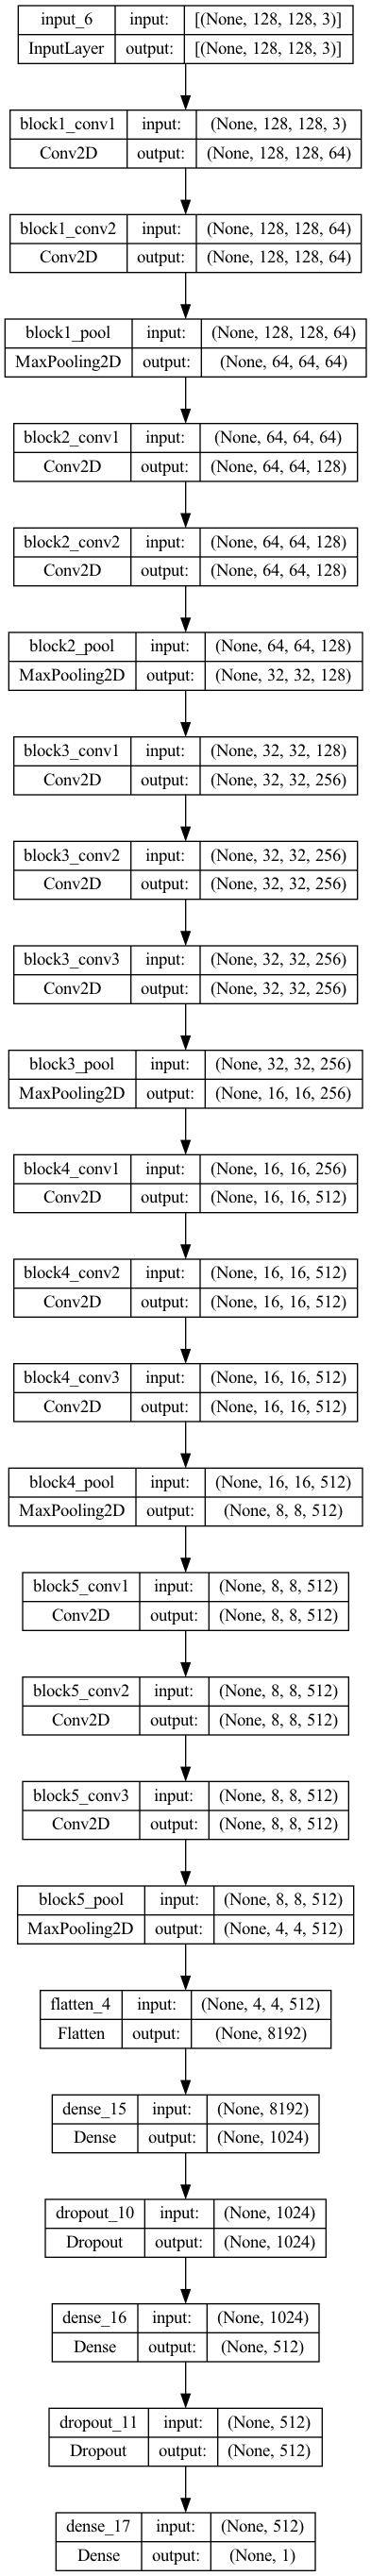

In [42]:
keras.utils.plot_model(model, show_shapes=True)

In [64]:
from sklearn.metrics import roc_curve, auc
score = model.evaluate(X_val, y_val, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)





score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr1, tpr1, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr1, tpr1)
print('Test ROC AUC:', roc_auc)

2/2 [==============================] - 1s 490ms/step - loss: 0.2585 - accuracy: 0.9153

Validation loss / accuracy: 0.2585 / 0.9153


2023-04-11 17:52:27.253467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 729ms/step
Validation ROC AUC: 0.7962962962962963
2/2 [==============================] - 1s 760ms/step - loss: 0.3979 - accuracy: 0.8793

Test loss / accuracy: 0.3979 / 0.8793
2/2 [==============================] - 1s 815ms/step
Test ROC AUC: 0.4145658263305322


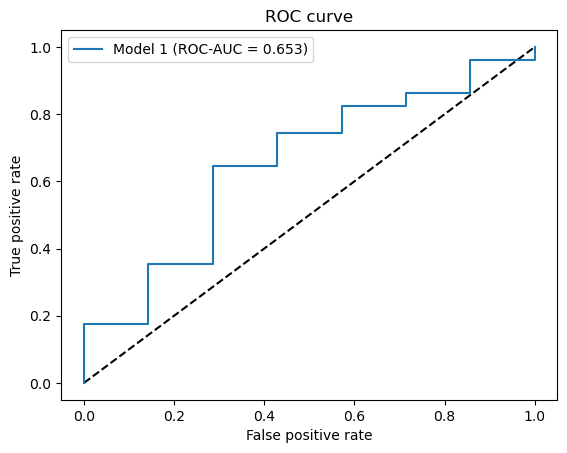

In [68]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr1, tpr1, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [66]:
model2 = keras.models.load_model('best_model_100threshold_6_good.h5')

In [67]:
score = model2.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model2.predict(X_test)
fpr1, tpr1, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr1, tpr1)
print('Test ROC AUC:', roc_auc)

2023-04-11 18:04:34.151208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 804ms/step - loss: 7.1452 - accuracy: 0.2586

Test loss / accuracy: 7.1452 / 0.2586


2023-04-11 18:04:36.394047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 623ms/step
Test ROC AUC: 0.6526610644257703


2/2 [==============================] - 1s 877ms/step


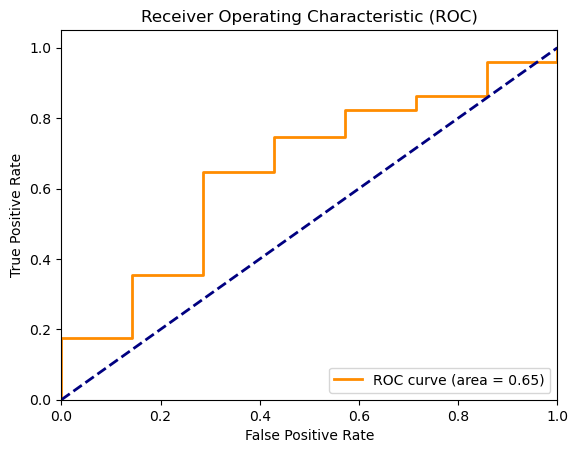

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predicted probabilities for the test set
y_pred_prob = model2.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()